# Merging objects

The `ObjectMerger` is a Random Forest Classifier that can learn which labels to merge and which not. It allows post-processing label images after objects have been (intentionally or not) oversegmented.

## Import packages ##

In [1]:
import apoc
from skimage.io import imread, imshow
import pyclesperanto_prototype as cle
import numpy as np
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari

A common example can be derived from an image showing intensities in cell membranes.

cl.OCLArray([[41., 63., 61., ..., 41., 39., 40.],
       [48., 54., 64., ..., 16., 26., 31.],
       [61., 60., 72., ..., 14., 44., 65.],
       ...,
       [67., 50., 39., ...,  1., 11., 14.],
       [66., 50., 67., ...,  0.,  0.,  4.],
       [75., 22., 54., ...,  0.,  0., 14.]], dtype=float32)
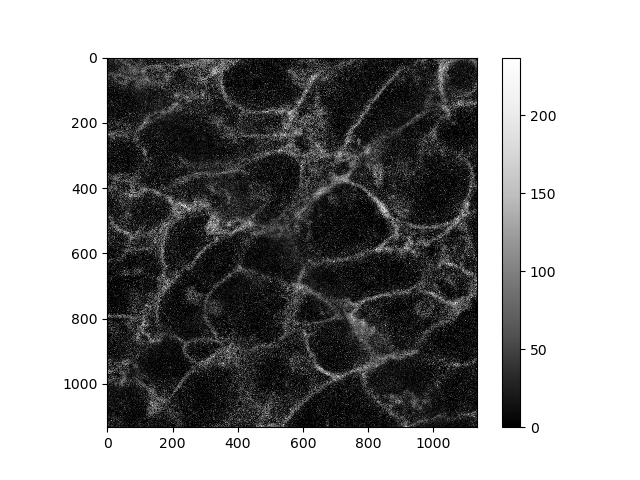
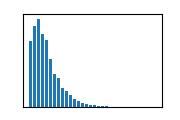

In [2]:
image = imread('slice.tif')#[::2,::2]
cle.asarray(image)

For technical reasons it is also recommeded to turn the intensity image into an image of type integer. Therefore, normalization might be necessary. It is important that images used for training and images used for prediction have intensities in the same range.

cl.OCLArray([[ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       [ 7,  7,  7, ...,  6,  6,  6],
       ...,
       [67, 67, 67, ..., 72, 72, 72],
       [67, 67, 67, ..., 72, 72, 72],
       [67, 67, 67, ..., 72, 72, 72]], dtype=uint32)
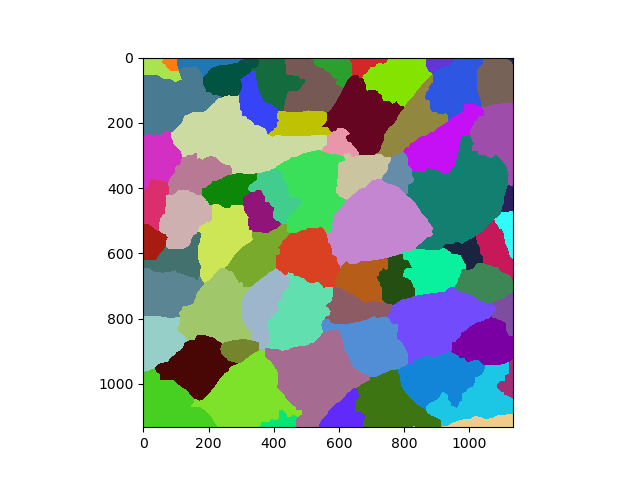

In [3]:
oversegmented = nsbatwm.local_minima_seeded_watershed(image, spot_sigma=20, outline_sigma=4)
cle.asarray(oversegmented).astype(np.uint32)

An annotation serves telling the algorithm which segmented objects should be merged and which not.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
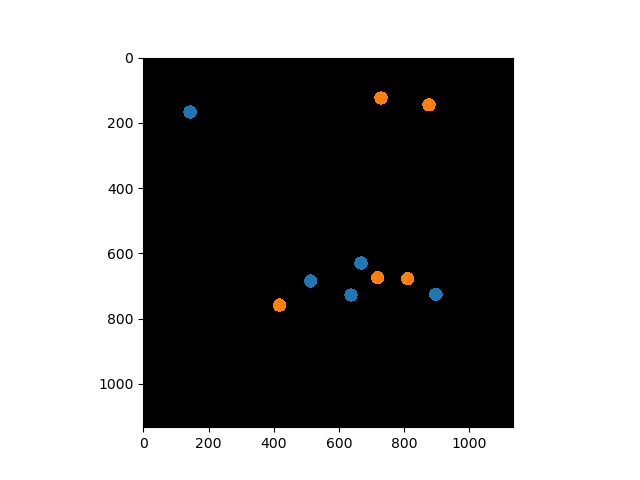

In [4]:
annotation = imread("edge_annotation.tif")
cle.asarray(annotation).astype(np.uint32)

For visualization purposes, we can overlay the annotation with the membrane image.

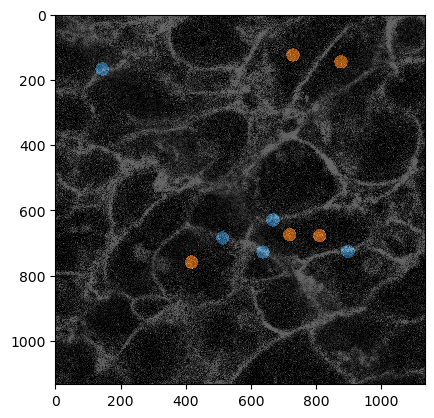

In [5]:
cle.imshow(image, max_display_intensity=100, continue_drawing=True)
cle.imshow(annotation, alpha=0.6, labels=True)

To show more closely what needs to be annotated, we also overlay the label-edge image and the annotation. Note that the edges which are not supposed to be merged are small dots always carefully only annotating two objects (that should not be merged. 

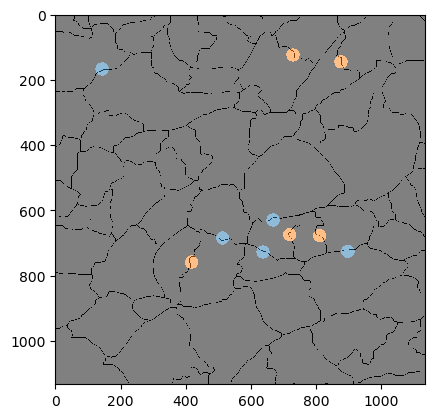

In [32]:
cle.imshow(cle.detect_label_edges(oversegmented), continue_drawing=True, colormap='Greys')
cle.imshow(annotation, alpha=0.5, labels=True)

## Training the merger

The `LabelMerger` can be trained using three features:
* `touch_portion`: The relative amount an object touches another. E.g. in a symmetric, honey-comb like tissue, neighboring cells have a touch-portion of `1/6` to each other.
* `touch_count`: The number of pixels where object touch. When using this parameter, make sure that images used for training and prediction have the same voxel size. 
* `mean_touch_intensity`: The mean average intensity between touching objects. If a cell is over-segmented, there are multiple objects found within that cell. The area where these objects touch has a lower intensity than the area where two cells touch. Thus, they can be differentiated. Normalizing the image as shown above is key.
* `centroid_distance`: The distance (in pixels or voxels) between centroids of labeled objects. 
* `mean_intensity_difference`: The absolute difference between the mean intensity of the two objects. This measurement allows differentiating bright and dark object and [not] merging them.
* `standard_deviation_intensity_difference`: The absolute difference between the standard deviation of the two objects. This measurement allows to differentiate [in]homogeneous objects and [not] merge them.
* `area_difference`: The difference in area/volume/pixel-count allows differentiating small and large objects and [not] merging them.
* `mean_max_distance_to_centroid_ratio_difference`: This parameter is a shape descriptor, similar to elongation, allowing to differentiate roundish and elongate object and [not] merging them.

Note: most features are recommended to be used in isotropic images only.

In [34]:
feature_definition = "touch_portion mean_touch_intensity"

classifier_filename = "label_merger.cl"

apoc.erase_classifier(classifier_filename)

classifier = apoc.ObjectMerger(opencl_filename=classifier_filename)

classifier.train(features=feature_definition,
                 labels=oversegmented,
                 sparse_annotation=annotation,
                 image=image) 

/opt/miniconda3/envs/napari-devbio/lib/python3.9/site-packages/pyclesperanto_prototype/_tier3/_generate_touch_mean_intensity_matrix.py:30: UserWarning: generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.
Loss of information is possible when passing non-integer images.
  warnings.warn("generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.\n" +


/opt/miniconda3/envs/napari-devbio/lib/python3.9/site-packages/pyclesperanto_prototype/_tier3/_generate_touch_mean_intensity_matrix.py:30: UserWarning: generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.
Loss of information is possible when passing non-integer images.
  warnings.warn("generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.\n" +


cl.OCLArray([[ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       [ 6,  6,  6, ...,  5,  5,  5],
       ...,
       [53, 53, 53, ..., 56, 56, 56],
       [53, 53, 53, ..., 56, 56, 56],
       [53, 53, 53, ..., 56, 56, 56]], dtype=uint32)
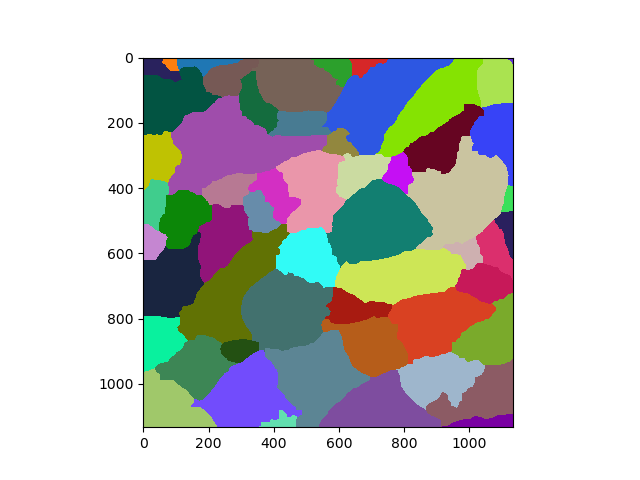

In [35]:
merged_labels = classifier.predict(labels=oversegmented, image=image)
merged_labels

## Viewer ##

In [9]:
viewer = napari.Viewer()
viewer.add_image(image,colormap='gray_r')
viewer.add_labels(merged_labels)

<Labels layer 'merged_labels' at 0x192c19490>

## Check pyopencl ##

`pyopencl` appears to access the M1 GPU correctly

In [10]:
# Import the Python OpenCL API
import pyopencl as cl

# Create a list of all the platform IDs
platforms = cl.get_platforms()

print("\nNumber of OpenCL platforms:", len(platforms))
print( "\n-------------------------")

for p in platforms:
    
    print( "Platform:", p.name)
    print( "Vendor:", p.vendor)
    print( "Version:", p.version)
    # Discover all devices
    devices = p.get_devices()
    print("Number of devices:", len(devices))
    
     # Investigate each device
    for d in devices:
        
        print("\t-------------------------")
        # Print out some information about the devices
        print("\t\tName:", d.name)
        print("\t\tVersion:", d.opencl_c_version)
        print("\t\tMax. Compute Units:", d.max_compute_units)
        print("\t\tLocal Memory Size:", d.local_mem_size/1024, "KB")
        print("\t\tGlobal Memory Size:", d.global_mem_size/(1024*1024), "MB")
        print("\t\tMax Alloc Size:", d.max_mem_alloc_size/(1024*1024), "MB")
        print("\t\tMax Work-group Total Size:", d.max_work_group_size)

        # Find the maximum dimensions of the work-groups
        dim = d.max_work_item_sizes
        print("\t\tMax Work-group Dims:(", dim[0], " ".join(map(str, dim[1:])), ")")

        print("\t-------------------------")

    print("\n-------------------------")


Number of OpenCL platforms: 1

-------------------------
Platform: Apple
Vendor: Apple
Version: OpenCL 1.2 (Aug  8 2022 21:29:33)
Number of devices: 3
	-------------------------
		Name: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
		Version: OpenCL C 1.2 
		Max. Compute Units: 12
		Local Memory Size: 32.0 KB
		Global Memory Size: 16384.0 MB
		Max Alloc Size: 4096.0 MB
		Max Work-group Total Size: 1024
		Max Work-group Dims:( 1024 1 1 )
	-------------------------
	-------------------------
		Name: Intel(R) UHD Graphics 630
		Version: OpenCL C 1.2 
		Max. Compute Units: 24
		Local Memory Size: 64.0 KB
		Global Memory Size: 1536.0 MB
		Max Alloc Size: 384.0 MB
		Max Work-group Total Size: 256
		Max Work-group Dims:( 256 256 256 )
	-------------------------
	-------------------------
		Name: AMD Radeon Pro 560X Compute Engine
		Version: OpenCL C 1.2 
		Max. Compute Units: 16
		Local Memory Size: 32.0 KB
		Global Memory Size: 4096.0 MB
		Max Alloc Size: 1024.0 MB
		Max Work-group Total Size: 2

## Show environment packages ##

In [11]:
# ! conda list

```
# packages in environment at /Users/jwhite/miniforge3/envs/tf-napari:
#
# Name                    Version                   Build  Channel
_ipython_minor_entry_point 8.7.0                hb6b4a82_0    conda-forge
absl-py                   1.3.0                    pypi_0    pypi
alabaster                 0.7.13             pyhd8ed1ab_0    conda-forge
altair                    4.2.0              pyhd8ed1ab_1    conda-forge
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
aom                       3.5.0                h7ea286d_0    conda-forge
apoc                      0.12.0                   pypi_0    pypi
app-model                 0.1.1              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
appnope                   0.1.3              pyhd8ed1ab_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h8e9501a_3    conda-forge
arrow                     1.2.3                    pypi_0    pypi
asciitree                 0.3.3                      py_2    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
astunparse                1.6.3                    pypi_0    pypi
attrs                     22.2.0             pyh71513ae_0    conda-forge
autopep8                  2.0.1                    pypi_0    pypi
babel                     2.11.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.11.1             pyha770c72_0    conda-forge
bleach                    6.0.0              pyhd8ed1ab_0    conda-forge
blosc                     1.21.3               h1d6ff8b_0    conda-forge
bokeh                     2.4.3              pyhd8ed1ab_3    conda-forge
brotli                    1.0.9                h1a8c8d9_8    conda-forge
brotli-bin                1.0.9                h1a8c8d9_8    conda-forge
brotlipy                  0.7.0           py310h8e9501a_1005    conda-forge
brunsli                   0.1                  h9f76cd9_0    conda-forge
bzip2                     1.0.8                h3422bc3_4    conda-forge
c-ares                    1.18.1               h3422bc3_0    conda-forge
c-blosc2                  2.6.1                h303ed30_0    conda-forge
ca-certificates           2022.12.7            h4653dfc_0    conda-forge
cached-property           1.5.2                hd8ed1ab_1    conda-forge
cached_property           1.5.2              pyha770c72_1    conda-forge
cachetools                5.2.0                    pypi_0    pypi
cachey                    0.2.1              pyh9f0ad1d_0    conda-forge
cellpose                  2.1.1                    pypi_0    pypi
certifi                   2022.12.7          pyhd8ed1ab_0    conda-forge
cffi                      1.15.1          py310h2399d43_3    conda-forge
cfitsio                   4.2.0                h2f961c4_0    conda-forge
charls                    2.4.1                hb7217d7_0    conda-forge
charset-normalizer        2.1.1              pyhd8ed1ab_0    conda-forge
click                     8.1.3           unix_pyhd8ed1ab_2    conda-forge
cloudpickle               2.2.1              pyhd8ed1ab_0    conda-forge
colorama                  0.4.6              pyhd8ed1ab_0    conda-forge
comm                      0.1.2              pyhd8ed1ab_0    conda-forge
commonmark                0.9.1                      py_0    conda-forge
conda                     22.11.1         py310hbe9552e_1    conda-forge
conda-package-handling    2.0.2              pyh38be061_0    conda-forge
conda-package-streaming   0.7.0              pyhd8ed1ab_1    conda-forge
contourpy                 1.0.7           py310h2887b22_0    conda-forge
cryptography              39.0.0          py310hfc83b78_0    conda-forge
csbdeep                   0.7.2                    pypi_0    pypi
cycler                    0.11.0             pyhd8ed1ab_0    conda-forge
cytoolz                   0.12.0          py310h8e9501a_1    conda-forge
dask                      2023.1.0           pyhd8ed1ab_0    conda-forge
dask-core                 2023.1.0           pyhd8ed1ab_0    conda-forge
dataclasses               0.8                pyhc8e2a94_3    conda-forge
dav1d                     1.0.0                he4db4b2_1    conda-forge
debugpy                   1.6.6           py310h0f1eb42_0    conda-forge
decorator                 5.1.1              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
distributed               2023.1.0           pyhd8ed1ab_0    conda-forge
docstring_parser          0.15               pyhd8ed1ab_0    conda-forge
docutils                  0.17.1          py310hbe9552e_3    conda-forge
entrypoints               0.4                pyhd8ed1ab_0    conda-forge
executing                 1.2.0              pyhd8ed1ab_0    conda-forge
expat                     2.5.0                hb7217d7_0    conda-forge
fasteners                 0.17.3             pyhd8ed1ab_0    conda-forge
fastremap                 1.13.3                   pypi_0    pypi
flatbuffers               22.12.6                  pypi_0    pypi
flit-core                 3.8.0              pyhd8ed1ab_0    conda-forge
fmt                       9.1.0                hffc8910_0    conda-forge
font-ttf-dejavu-sans-mono 2.37                 hab24e00_0    conda-forge
font-ttf-inconsolata      3.000                h77eed37_0    conda-forge
font-ttf-source-code-pro  2.038                h77eed37_0    conda-forge
font-ttf-ubuntu           0.83                 hab24e00_0    conda-forge
fontconfig                2.14.1               h82840c6_0    conda-forge
fonts-conda-ecosystem     1                             0    conda-forge
fonts-conda-forge         1                             0    conda-forge
fonttools                 4.38.0          py310h8e9501a_1    conda-forge
fqdn                      1.5.1                    pypi_0    pypi
freetype                  2.12.1               hd633e50_1    conda-forge
freetype-py               2.3.0              pyhd8ed1ab_0    conda-forge
fsspec                    2023.1.0           pyhd8ed1ab_0    conda-forge
future                    0.18.3             pyhd8ed1ab_0    conda-forge
gast                      0.4.0                    pypi_0    pypi
gettext                   0.21.1               h0186832_0    conda-forge
giflib                    5.2.1                h27ca646_2    conda-forge
gitdb                     4.0.10             pyhd8ed1ab_0    conda-forge
gitpython                 3.1.30             pyhd8ed1ab_0    conda-forge
glib                      2.74.1               hb5ab8b9_1    conda-forge
glib-tools                2.74.1               hb5ab8b9_1    conda-forge
google-auth               2.15.0                   pypi_0    pypi
google-auth-oauthlib      0.4.6                    pypi_0    pypi
google-pasta              0.2.0                    pypi_0    pypi
grpcio                    1.46.3          py310ha26ec5d_0    conda-forge
gst-plugins-base          1.21.3               h8b7775e_1    conda-forge
gstreamer                 1.21.3               hcb7b3dd_1    conda-forge
h5py                      3.6.0           nompi_py310hb8bbf05_100    conda-forge
hdf5                      1.12.1          nompi_hd9dbc9e_104    conda-forge
heapdict                  1.0.1                      py_0    conda-forge
hsluv                     5.0.2              pyh44b312d_0    conda-forge
icu                       70.1                 h6b3803e_0    conda-forge
idna                      3.4                pyhd8ed1ab_0    conda-forge
imagecodecs               2023.1.23       py310hd30fb6a_0    conda-forge
imageio                   2.25.0             pyh24c5eb1_0    conda-forge
imagesize                 1.4.1              pyhd8ed1ab_0    conda-forge
importlib-metadata        6.0.0              pyha770c72_0    conda-forge
importlib_resources       5.10.2             pyhd8ed1ab_0    conda-forge
in-n-out                  0.1.6              pyhd8ed1ab_0    conda-forge
ipycanvas                 0.13.1                   pypi_0    pypi
ipyevents                 2.0.1                    pypi_0    pypi
ipykernel                 6.20.2             pyh736e0ef_0    conda-forge
ipython                   8.7.0              pyhd1c38e8_0    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
ipywidgets                8.0.4                    pypi_0    pypi
isoduration               20.11.0                  pypi_0    pypi
jedi                      0.18.2             pyhd8ed1ab_0    conda-forge
jinja2                    3.1.2              pyhd8ed1ab_1    conda-forge
joblib                    1.2.0              pyhd8ed1ab_0    conda-forge
jpeg                      9e                   he4db4b2_2    conda-forge
json5                     0.9.5              pyh9f0ad1d_0    conda-forge
jsonpointer               2.3                      pypi_0    pypi
jsonschema                4.17.3             pyhd8ed1ab_0    conda-forge
jupyter                   1.0.0                    pypi_0    pypi
jupyter-console           6.4.4                    pypi_0    pypi
jupyter-server-mathjax    0.2.6              pyh5bfe37b_1    conda-forge
jupyter_client            7.4.9              pyhd8ed1ab_0    conda-forge
jupyter_core              5.1.4           py310hbe9552e_0    conda-forge
jupyter_events            0.6.3              pyhd8ed1ab_0    conda-forge
jupyter_server            2.1.0              pyhd8ed1ab_0    conda-forge
jupyter_server_terminals  0.4.4              pyhd8ed1ab_1    conda-forge
jupyterlab                3.5.3              pyhd8ed1ab_0    conda-forge
jupyterlab-git            0.41.0             pyhd8ed1ab_1    conda-forge
jupyterlab-widgets        3.0.5                    pypi_0    pypi
jupyterlab_pygments       0.2.2              pyhd8ed1ab_0    conda-forge
jupyterlab_server         2.19.0             pyhd8ed1ab_0    conda-forge
jupytext                  1.14.4                   pypi_0    pypi
jxrlib                    1.1                  h27ca646_2    conda-forge
keras                     2.11.0                   pypi_0    pypi
khronos-opencl-icd-loader 2022.09.30           h1a8c8d9_2    conda-forge
kiwisolver                1.4.4           py310h2887b22_1    conda-forge
krb5                      1.20.1               h69eda48_0    conda-forge
lcms2                     2.14                 h481adae_1    conda-forge
lerc                      4.0.0                h9a09cb3_0    conda-forge
libaec                    1.0.6                hb7217d7_1    conda-forge
libarchive                3.6.2                h83f22c9_0    conda-forge
libavif                   0.11.1               h3d80962_0    conda-forge
libblas                   3.9.0           16_osxarm64_openblas    conda-forge
libbrotlicommon           1.0.9                h1a8c8d9_8    conda-forge
libbrotlidec              1.0.9                h1a8c8d9_8    conda-forge
libbrotlienc              1.0.9                h1a8c8d9_8    conda-forge
libcblas                  3.9.0           16_osxarm64_openblas    conda-forge
libclang                  14.0.6                   pypi_0    pypi
libclang13                14.0.6          default_he70ec0d_0    conda-forge
libcurl                   7.87.0               h9049daf_0    conda-forge
libcxx                    14.0.6               h2692d47_0    conda-forge
libdeflate                1.17                 h1a8c8d9_0    conda-forge
libedit                   3.1.20191231         hc8eb9b7_2    conda-forge
libev                     4.33                 h642e427_1    conda-forge
libffi                    3.4.2                h3422bc3_5    conda-forge
libgfortran               5.0.0           11_3_0_hd922786_27    conda-forge
libgfortran5              11.3.0              hdaf2cc0_27    conda-forge
libglib                   2.74.1               h4646484_1    conda-forge
libiconv                  1.17                 he4db4b2_0    conda-forge
libjpeg-turbo             2.1.4                h1a8c8d9_0    conda-forge
liblapack                 3.9.0           16_osxarm64_openblas    conda-forge
libllvm14                 14.0.6               hf6e71e7_1    conda-forge
libmamba                  1.2.0                h7d1d596_0    conda-forge
libmambapy                1.2.0           py310h34b6e76_0    conda-forge
libnghttp2                1.51.0               hae82a92_0    conda-forge
libogg                    1.3.4                h27ca646_1    conda-forge
libopenblas               0.3.21          openmp_hc731615_3    conda-forge
libopus                   1.3.1                h27ca646_1    conda-forge
libpng                    1.6.39               h76d750c_0    conda-forge
libpq                     15.1                 h1a28acd_3    conda-forge
libprotobuf               3.19.4               hccf11d3_0    conda-forge
libsodium                 1.0.18               h27ca646_1    conda-forge
libsolv                   0.7.23               hb5ab8b9_0    conda-forge
libsqlite                 3.40.0               h76d750c_0    conda-forge
libssh2                   1.10.0               h7a5bd25_3    conda-forge
libtiff                   4.5.0                h5dffbdd_2    conda-forge
libuv                     1.44.2               he4db4b2_0    conda-forge
libvorbis                 1.3.7                h9f76cd9_0    conda-forge
libwebp-base              1.2.4                h57fd34a_0    conda-forge
libxcb                    1.13              h9b22ae9_1004    conda-forge
libxml2                   2.10.3               h87b0503_0    conda-forge
libzlib                   1.2.13               h03a7124_4    conda-forge
libzopfli                 1.0.3                h9f76cd9_0    conda-forge
llvm-openmp               15.0.7               h7cfbb63_0    conda-forge
llvmlite                  0.39.1                   pypi_0    pypi
locket                    1.0.0              pyhd8ed1ab_0    conda-forge
loguru                    0.6.0                    pypi_0    pypi
lz4                       4.2.0           py310ha6df754_0    conda-forge
lz4-c                     1.9.3                hbdafb3b_1    conda-forge
lzo                       2.10              h642e427_1000    conda-forge
magicgui                  0.6.1              pyhd8ed1ab_0    conda-forge
mako                      1.2.4              pyhd8ed1ab_0    conda-forge
mamba                     1.2.0           py310ha5d4528_0    conda-forge
markdown                  3.4.1                    pypi_0    pypi
markdown-it-py            2.1.0                    pypi_0    pypi
markupsafe                2.1.2           py310h8e9501a_0    conda-forge
matplotlib-base           3.6.3           py310h78c5c2f_0    conda-forge
matplotlib-inline         0.1.6              pyhd8ed1ab_0    conda-forge
mdit-py-plugins           0.3.3                    pypi_0    pypi
mdurl                     0.1.2                    pypi_0    pypi
mistune                   2.0.4              pyhd8ed1ab_0    conda-forge
msgpack-python            1.0.4           py310h2887b22_1    conda-forge
munkres                   1.1.4              pyh9f0ad1d_0    conda-forge
mypy_extensions           0.4.3           py310hbe9552e_6    conda-forge
mysql-common              8.0.31               h518ea0a_0    conda-forge
mysql-libs                8.0.31               hcb599eb_0    conda-forge
napari                    0.4.17          pyh275ddea_0_pyqt    conda-forge
napari-accelerated-pixel-and-object-classification 0.12.2                   pypi_0    pypi
napari-assistant          0.4.4                    pypi_0    pypi
napari-console            0.0.7              pyhd8ed1ab_0    conda-forge
napari-crop               0.1.6                    pypi_0    pypi
napari-plugin-engine      0.2.0              pyhd8ed1ab_2    conda-forge
napari-segment-blobs-and-things-with-membranes 0.3.3                    pypi_0    pypi
napari-simpleitk-image-processing 0.4.4                    pypi_0    pypi
napari-skimage-regionprops 0.6.0                    pypi_0    pypi
napari-svg                0.1.6              pyhd8ed1ab_1    conda-forge
napari-time-slicer        0.4.9                    pypi_0    pypi
napari-tools-menu         0.1.18                   pypi_0    pypi
napari-workflows          0.2.8                    pypi_0    pypi
natsort                   8.2.0                    pypi_0    pypi
nbclassic                 0.4.8              pyhd8ed1ab_0    conda-forge
nbclient                  0.7.2              pyhd8ed1ab_0    conda-forge
nbconvert                 7.2.8              pyhd8ed1ab_0    conda-forge
nbconvert-core            7.2.8              pyhd8ed1ab_0    conda-forge
nbconvert-pandoc          7.2.8              pyhd8ed1ab_0    conda-forge
nbdime                    3.1.1              pyhd8ed1ab_0    conda-forge
nbformat                  5.7.3              pyhd8ed1ab_0    conda-forge
ncurses                   6.3                  h07bb92c_1    conda-forge
nest-asyncio              1.5.6              pyhd8ed1ab_0    conda-forge
networkx                  3.0                pyhd8ed1ab_0    conda-forge
nodejs                    18.12.1              h26a3f6d_0    conda-forge
notebook                  6.5.2              pyha770c72_1    conda-forge
notebook-shim             0.2.2              pyhd8ed1ab_0    conda-forge
npe2                      0.6.1              pyhd8ed1ab_1    conda-forge
nspr                      4.35                 hb7217d7_0    conda-forge
nss                       3.78                 h1483a63_0    conda-forge
numba                     0.56.4                   pypi_0    pypi
numcodecs                 0.11.0          py310h0f1eb42_1    conda-forge
numpy                     1.23.2          py310h127c7cf_0    conda-forge
numpydoc                  1.5.0              pyhd8ed1ab_0    conda-forge
oauthlib                  3.2.2                    pypi_0    pypi
ocl_icd_wrapper_apple     1.0.0                h27ca646_0    conda-forge
opencv-python-headless    4.6.0.66                 pypi_0    pypi
openjpeg                  2.5.0                hbc2ba62_2    conda-forge
openssl                   3.0.7                h03a7124_1    conda-forge
opt-einsum                3.3.0                    pypi_0    pypi
packaging                 23.0               pyhd8ed1ab_0    conda-forge
pandas                    1.5.3           py310h2b830bf_0    conda-forge
pandoc                    2.19.2               hce30654_1    conda-forge
pandocfilters             1.5.0              pyhd8ed1ab_0    conda-forge
parso                     0.8.3              pyhd8ed1ab_0    conda-forge
partd                     1.3.0              pyhd8ed1ab_0    conda-forge
patsy                     0.5.3              pyhd8ed1ab_0    conda-forge
pcre2                     10.40                hb34f9b4_0    conda-forge
pep517                    0.13.0             pyhd8ed1ab_0    conda-forge
pexpect                   4.8.0              pyh1a96a4e_2    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    9.4.0           py310h5f2e7f5_0    conda-forge
pint                      0.20.1             pyhd8ed1ab_0    conda-forge
pip                       22.3.1             pyhd8ed1ab_0    conda-forge
pkgutil-resolve-name      1.3.10             pyhd8ed1ab_0    conda-forge
platformdirs              2.6.2              pyhd8ed1ab_0    conda-forge
pluggy                    1.0.0              pyhd8ed1ab_5    conda-forge
ply                       3.11                       py_1    conda-forge
pooch                     1.6.0              pyhd8ed1ab_0    conda-forge
prometheus_client         0.16.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.36             pyha770c72_0    conda-forge
protobuf                  3.19.4          py310h1b49c16_0    conda-forge
psutil                    5.9.4           py310h8e9501a_0    conda-forge
psygnal                   0.7.0              pyhd8ed1ab_0    conda-forge
pthread-stubs             0.4               h27ca646_1001    conda-forge
ptyprocess                0.7.0              pyhd3deb0d_0    conda-forge
pure_eval                 0.2.2              pyhd8ed1ab_0    conda-forge
pyasn1                    0.4.8                    pypi_0    pypi
pyasn1-modules            0.2.8                    pypi_0    pypi
pybind11-abi              4                    hd8ed1ab_3    conda-forge
pyclesperanto-prototype   0.22.0             pyhd8ed1ab_0    conda-forge
pycodestyle               2.10.0                   pypi_0    pypi
pycosat                   0.6.4           py310h8e9501a_1    conda-forge
pycparser                 2.21               pyhd8ed1ab_0    conda-forge
pydantic                  1.10.4          py310h8e9501a_1    conda-forge
pygments                  2.14.0             pyhd8ed1ab_0    conda-forge
pyopencl                  2022.3.1        py310h629746b_0    conda-forge
pyopengl                  3.1.6              pyhd8ed1ab_1    conda-forge
pyopenssl                 23.0.0             pyhd8ed1ab_0    conda-forge
pyparsing                 3.0.9              pyhd8ed1ab_0    conda-forge
pyperclip                 1.8.2                    pypi_0    pypi
pyproject_hooks           1.0.0              pyhd8ed1ab_0    conda-forge
pyqt                      5.15.7          py310h7aaa74b_2    conda-forge
pyqt5-sip                 12.11.0         py310h0f1eb42_2    conda-forge
pyrsistent                0.19.3          py310h8e9501a_0    conda-forge
pysocks                   1.7.1              pyha2e5f31_6    conda-forge
python                    3.10.8          h3ba56d0_0_cpython    conda-forge
python-build              0.10.0             pyhd8ed1ab_0    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python-fastjsonschema     2.16.2             pyhd8ed1ab_0    conda-forge
python-json-logger        2.0.4              pyhd8ed1ab_0    conda-forge
python_abi                3.10                    3_cp310    conda-forge
pytomlpp                  1.0.11          py310h2887b22_1    conda-forge
pytools                   2022.1.14          pyhd8ed1ab_0    conda-forge
pytz                      2022.7.1           pyhd8ed1ab_0    conda-forge
pywavelets                1.4.1           py310hf1a086a_0    conda-forge
pyyaml                    6.0             py310h8e9501a_5    conda-forge
pyzmq                     25.0.0          py310hc407298_0    conda-forge
qt-main                   5.15.6               hda43d4a_6    conda-forge
qtconsole-base            5.4.0              pyha770c72_0    conda-forge
qtpy                      2.3.0              pyhd8ed1ab_0    conda-forge
readline                  8.1.2                h46ed386_0    conda-forge
reproc                    14.2.4               h1a8c8d9_0    conda-forge
reproc-cpp                14.2.4               hb7217d7_0    conda-forge
requests                  2.28.2             pyhd8ed1ab_0    conda-forge
requests-oauthlib         1.3.1                    pypi_0    pypi
rfc3339-validator         0.1.4              pyhd8ed1ab_0    conda-forge
rfc3986-validator         0.1.1              pyh9f0ad1d_0    conda-forge
rich                      12.6.0             pyhd8ed1ab_0    conda-forge
rsa                       4.9                      pypi_0    pypi
ruamel.yaml               0.17.21         py310h8e9501a_2    conda-forge
ruamel.yaml.clib          0.2.7           py310h8e9501a_1    conda-forge
scikit-image              0.19.3          py310h2b830bf_2    conda-forge
scikit-learn              1.2.0           py310ha00a7cd_0    conda-forge
scipy                     1.10.0          py310ha0d8a01_0    conda-forge
seaborn                   0.12.2               hd8ed1ab_0    conda-forge
seaborn-base              0.12.2             pyhd8ed1ab_0    conda-forge
send2trash                1.8.0              pyhd8ed1ab_0    conda-forge
setuptools                66.1.1             pyhd8ed1ab_0    conda-forge
shellingham               1.5.0.post1        pyhd8ed1ab_0    conda-forge
simpleitk                 2.2.1                    pypi_0    pypi
sip                       6.7.5           py310h0f1eb42_0    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
smmap                     3.0.5              pyh44b312d_0    conda-forge
snappy                    1.1.9                h17c5cce_2    conda-forge
sniffio                   1.3.0              pyhd8ed1ab_0    conda-forge
snowballstemmer           2.2.0              pyhd8ed1ab_0    conda-forge
sortedcontainers          2.4.0              pyhd8ed1ab_0    conda-forge
soupsieve                 2.3.2.post1        pyhd8ed1ab_0    conda-forge
sphinx                    4.5.0              pyh6c4a22f_0    conda-forge
sphinxcontrib-applehelp   1.0.4              pyhd8ed1ab_0    conda-forge
sphinxcontrib-devhelp     1.0.2                      py_0    conda-forge
sphinxcontrib-htmlhelp    2.0.0              pyhd8ed1ab_0    conda-forge
sphinxcontrib-jsmath      1.0.1                      py_0    conda-forge
sphinxcontrib-qthelp      1.0.3                      py_0    conda-forge
sphinxcontrib-serializinghtml 1.1.5              pyhd8ed1ab_2    conda-forge
sqlite                    3.40.0               h2229b38_0    conda-forge
stack_data                0.6.2              pyhd8ed1ab_0    conda-forge
stackview                 0.4.0                    pypi_0    pypi
stardist                  0.8.3                    pypi_0    pypi
statsmodels               0.13.5          py310hf1a086a_2    conda-forge
superqt                   0.4.1              pyhd8ed1ab_0    conda-forge
tblib                     1.7.0              pyhd8ed1ab_0    conda-forge
tensorboard               2.11.0                   pypi_0    pypi
tensorboard-data-server   0.6.1                    pypi_0    pypi
tensorboard-plugin-wit    1.8.1                    pypi_0    pypi
tensorflow-deps           2.10.0                        0    apple
tensorflow-estimator      2.11.0                   pypi_0    pypi
tensorflow-macos          2.11.0                   pypi_0    pypi
termcolor                 2.1.1                    pypi_0    pypi
terminado                 0.17.1             pyhd1c38e8_0    conda-forge
threadpoolctl             3.1.0              pyh8a188c0_0    conda-forge
tifffile                  2023.1.23.1        pyhd8ed1ab_0    conda-forge
tinycss2                  1.2.1              pyhd8ed1ab_0    conda-forge
tk                        8.6.12               he1e0b03_0    conda-forge
toml                      0.10.2             pyhd8ed1ab_0    conda-forge
tomli                     2.0.1              pyhd8ed1ab_0    conda-forge
toolz                     0.12.0             pyhd8ed1ab_0    conda-forge
torch                     1.13.1                   pypi_0    pypi
tornado                   6.2             py310h8e9501a_1    conda-forge
tqdm                      4.64.1             pyhd8ed1ab_0    conda-forge
traitlets                 5.8.1              pyhd8ed1ab_0    conda-forge
transforms3d              0.4.1              pyhd8ed1ab_0    conda-forge
typer                     0.7.0              pyhd8ed1ab_0    conda-forge
typing-extensions         4.4.0                hd8ed1ab_0    conda-forge
typing_extensions         4.4.0              pyha770c72_0    conda-forge
tzdata                    2022g                h191b570_0    conda-forge
unicodedata2              15.0.0          py310h8e9501a_0    conda-forge
uri-template              1.2.0                    pypi_0    pypi
urllib3                   1.26.14            pyhd8ed1ab_0    conda-forge
vispy                     0.11.0          py310hb614ae6_1    conda-forge
vollseg                   6.0.5                    pypi_0    pypi
vollseg-napari            2.3.7                    pypi_0    pypi
wcwidth                   0.2.6              pyhd8ed1ab_0    conda-forge
webcolors                 1.12                     pypi_0    pypi
webencodings              0.5.1                      py_1    conda-forge
websocket-client          1.4.2              pyhd8ed1ab_0    conda-forge
werkzeug                  2.2.2                    pypi_0    pypi
wheel                     0.38.4             pyhd8ed1ab_0    conda-forge
widgetsnbextension        4.0.5                    pypi_0    pypi
wrapt                     1.14.1          py310h8e9501a_1    conda-forge
xorg-libxau               1.0.9                h27ca646_0    conda-forge
xorg-libxdmcp             1.1.3                h27ca646_0    conda-forge
xz                        5.2.6                h57fd34a_0    conda-forge
yaml                      0.2.5                h3422bc3_2    conda-forge
yaml-cpp                  0.7.0                hb7217d7_2    conda-forge
zarr                      2.13.3             pyhd8ed1ab_0    conda-forge
zeromq                    4.3.4                hbdafb3b_1    conda-forge
zfp                       1.0.0                hb6e4faa_3    conda-forge
zict                      2.2.0              pyhd8ed1ab_0    conda-forge
zipp                      3.11.0             pyhd8ed1ab_0    conda-forge
zlib                      1.2.13               h03a7124_4    conda-forge
zlib-ng                   2.0.6                he4db4b2_0    conda-forge
zstandard                 0.19.0          py310had9512b_1    conda-forge
zstd                      1.5.2                hf913c23_6    conda-forge

```